In [1]:
using Distributions
using LinearAlgebra
using Random
using StatsFuns
using StatsPlots
default(fmt=:png)

In [2]:
unbiased_estimator_of_C(K) = (n = sum(K); (dot(K, K) - n)/ (n*(n-1)))
#unbiased_estimator_of_T(K) = (n = sum(K); sum(k -> k*(k-1)*(k-2), K) / (n*(n-1)*(n-2)))
unbiased_estimator_of_sdi(K) = 1 - unbiased_estimator_of_C(K)

function _coefficients_abc(n)
    a = 4(n-2)/(n*(n-1))
    b = (4n-6)/(n*(n-1))
    c = 2/(n*(n-1))
    (; a, b, c)
end

function varhat_sdihat_plugin(K)
    n = sum(K)
    (; a, b, c) = _coefficients_abc(n)
    C̃ = dot(K, K) / n^2
    T̃ = sum(k -> k^3, K) / n^3
    max(0, a*T̃ - b*C̃^2 + c*C̃)
end
stdhat_sdihat_plugin(K) = √varhat_sdihat_plugin(K)

# Assume that dlink is the derivative of link.
function pvalue_sdi_linked(K, sdi; link=logit, dlink=x->1/x+1/(1-x))
    sdihat = unbiased_estimator_of_sdi(K)
    sehat = stdhat_sdihat_plugin(K)
    Δsdi_linked = link(sdihat) - link(sdi)
    sehat_linked = abs(dlink(sdihat)) * sehat
    z = safediv(Δsdi_linked, sehat_linked)
    2ccdf(Normal(), abs(z))
end

K = [10, 6, 3, 1, 1, 1]
sdi = 0.6
pvalue_sdi_linked(K, sdi)

LoadError: UndefVarError: `safediv` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

dir = Dirichlet([10, 6, 3, 1, 1, 1]) = Dirichlet{Int64, Vector{Int64}, Float64}(alpha=[10, 6, 3, 1, 1, 1])

expectval_sdi(dir) = 0.6640316205533596
expectval_sdi_naive(dir) = 0.6640316205533596

variance_sdi(dir) = 0.0040422440594291426
variance_sdi_naive(dir) = 0.0040422440594291426


K = [10, 6, 3, 1, 1, 1] = [10, 6, 3, 1, 1, 1]
unbiased_estimator_of_sdi(K) = 0.7272727272727273

pvalue_sdi_bayes(K, 0.5) = 0.016816963796752245
pvalue_sdi_bayes(K, 0.55, Dirichlet(fill(0.025, 100))) = 0.011875786843426833
pvalue_sdi_bayes(K, 0.65, Dirichlet(fill(1.0, 10))) = 0.010636658504695685



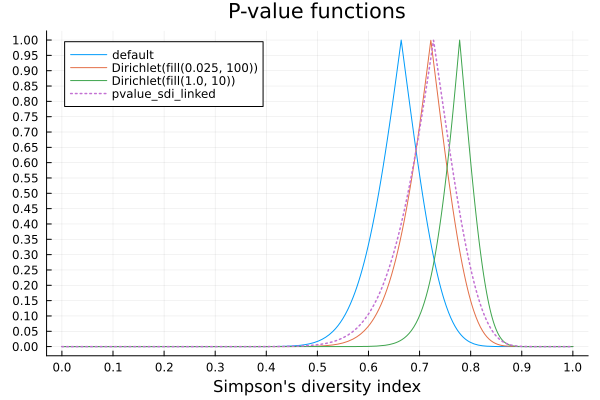

In [3]:
@inline safediv(x, y) = x == 0 ? zero(x/y) : isinf(x) ? x*sign(y) : x/y

@inline function expectval_sdi(dir::Dirichlet)
    κ = params(dir)[1]
    r = length(κ)
    ν = sum(κ)
    A = sum(κ[i]*(κ[i]+1) for i in 1:r)
    1 - A / (ν*(ν+1))
end

function expectval_sdi_naive(dir::Dirichlet)
    κ = params(dir)[1]
    ν = sum(κ)
    A2 = dot(κ, κ) + ν
    1 - A2 / (ν*(ν+1))
end

@inline function variance_sdi(dir::Dirichlet)
    κ = params(dir)[1]
    ν = sum(κ)
    A2 = dot(κ, κ) + ν
    A3 = sum(κ->κ*(κ+1)*(κ+2), κ)
    (A2^2 + 4A3 - 2A2)/(ν*(ν+1)*(ν+2)*(ν+3)) - (A2 / (ν*(ν+1)))^2
end

function variance_sdi_naive(dir::Dirichlet)
    κ = params(dir)[1]
    r = length(κ)
    ν = sum(κ)
    A = sum(κ[i]*(κ[i]+1) for i in 1:r)
    B = sum(κ[i]*(κ[i]+1)*(κ[i]+2)*(κ[i]+3) for i in 1:r)
    C = sum(κ[i]*(κ[i]+1)*κ[j]*(κ[j]+1) for i in 1:r-1 for j in i+1:r)
    (B + 2C)/(ν*(ν+1)*(ν+2)*(ν+3)) - (A/(ν*(ν+1)))^2
end

# Assume that dlink is the derivative of link.
function pvalue_sdi_bayes(K::Vector, sdi, prior::Dirichlet=Dirichlet(fill(eps()^2, length(K)));
        link=logit, dlink=x->1/x+1/(1-x))
    κ_pri = params(prior)[1]
    κ_post = [get(K, i, zero(eltype(K))) + get(κ_pri, i, zero(eltype(κ_pri)))
        for i in 1:max(length(K), length(κ_pri))]
    posterior = Dirichlet(κ_post)
    sdihat = expectval_sdi(posterior)
    sehat = √max(0, variance_sdi(posterior))
    Δsdi_linked = link(sdihat) - link(sdi)
    sehat_linked = abs(dlink(sdihat)) * sehat
    z = safediv(Δsdi_linked, sehat_linked)
    2ccdf(Normal(), abs(z))
end

@show dir = Dirichlet([10, 6, 3, 1, 1, 1])
println()
@show expectval_sdi(dir)
@show expectval_sdi_naive(dir)
println()
@show variance_sdi(dir)
@show variance_sdi_naive(dir)
println()
println()
@show K = [10, 6, 3, 1, 1, 1]
@show unbiased_estimator_of_sdi(K)
println()
@show pvalue_sdi_bayes(K, 0.5)
@show pvalue_sdi_bayes(K, 0.55, Dirichlet(fill(0.025, 100)))
@show pvalue_sdi_bayes(K, 0.65, Dirichlet(fill(1.0, 10)))
println()

plot()
plot!(sdi -> pvalue_sdi_bayes(K, sdi), 0, 1; label="default")
plot!(sdi -> pvalue_sdi_bayes(K, sdi, Dirichlet(fill(0.025, 100))), 0, 1; label="Dirichlet(fill(0.025, 100))")
plot!(sdi -> pvalue_sdi_bayes(K, sdi, Dirichlet(fill(1.0, 10))), 0, 1; label="Dirichlet(fill(1.0, 10))")
plot!(sdi -> pvalue_sdi_linked(K, sdi), 0, 1; label="pvalue_sdi_linked", ls=:dot, lw=1.5)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)
plot!(xguide="Simpson's diversity index")
title!("P-value functions")

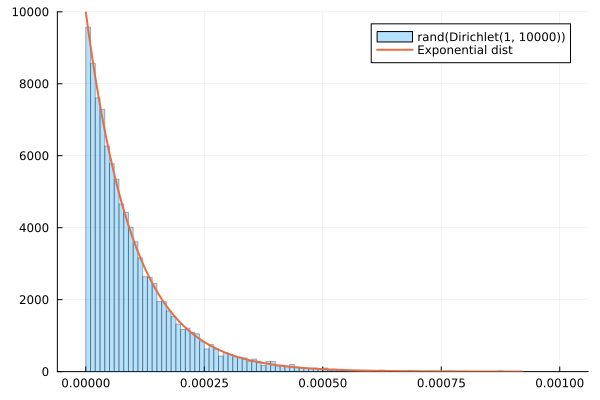

In [4]:
r = 10000
X = rand(Dirichlet(fill(1, r)))
histogram(X; norm=true, alpha=0.3, label="rand(Dirichlet(1, $r))")
plot!(Exponential(mean(X)); label="Exponential dist", lw=2)
plot!(xlim=(-0.6/r, 10.6/r))

length(κ_pri) = 1000
mean(κ_pri) = 1.0
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.998001998001998
variance_sdi(prior) = 3.96815538617257e-9
  1.801866 seconds (1.26 M allocations: 794.387 MiB, 6.16% gc time, 130.41% compilation time)


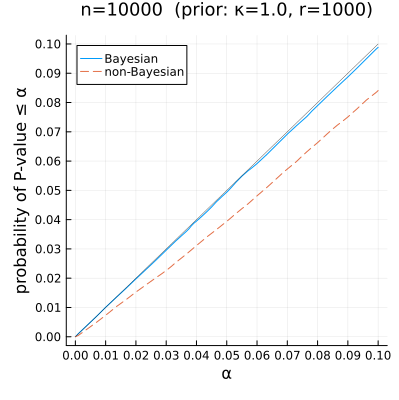

In [5]:
_ecdf(A, x) = count(≤(x), A) / length(A)

function sim_pval(;
        n = 100,
        prior = Dirichlet(fill(1.0, 100)),
        niters = 30000,
    )
    pval_bayes = zeros(niters)
    pval_nonbayes = zeros(niters)
    nth = Threads.nthreads()
    r = length(params(prior)[1])
    Ptmp = [zeros(r) for _ in 1:nth]
    Ktmp = [zeros(Int, r) for _ in 1:nth]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        P = rand!(prior, Ptmp[tid])
        sdi = 1 - dot(P, P)
        mult = Multinomial(n, P)
        K = rand!(mult, Ktmp[tid])
        pval_bayes[i] = pvalue_sdi_bayes(K, sdi, prior)
        pval_nonbayes[i] = pvalue_sdi_linked(K, sdi)
    end
    (; pval_bayes, pval_nonbayes)
end

function plot_sim_pval(;
        n = 10000,
        κ = 1.0,
        r = 1000,
        ε = eps()^2,
        s = 0,
        niters = 10^5,
        f = Bool[1, 0],
    )
    κ_pri = [fill(κ, r); fill(ε, s)]
    prior = Dirichlet(κ_pri)
    @show length(κ_pri) mean(κ_pri) std(κ_pri)
    @show expectval_sdi(prior)
    @show variance_sdi(prior)
    @time (; pval_bayes, pval_nonbayes) = sim_pval(; n, prior, niters)
    plot()
    f[1] && plot!(α -> _ecdf(pval_bayes, α), 0, 0.1; label="Bayesian")
    f[2] && plot!(α -> _ecdf(pval_nonbayes, α), 0, 0.1; label="non-Bayesian", ls=:dash)
    plot!(identity; label="", c=:black, lw=0.3)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(xguide="α", yguide="probability of P-value ≤ α")
    plot!(size=(400, 400))
    title!("n=$n  (prior: κ=$κ, r=$r" * (s==0 ? "" : ", s=$s") * ")", titlefontsize=12)
end

plot_sim_pval(; f=Bool[1,1])

length(κ_pri) = 100
mean(κ_pri) = 1.0
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9801980198019802
variance_sdi(prior) = 3.6950050977073694e-6
  0.091299 seconds (899.74 k allocations: 100.739 MiB, 15.65% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.5
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9705882352941176
variance_sdi(prior) = 2.0716047026682295e-5
  0.129959 seconds (899.74 k allocations: 100.739 MiB, 4.93% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.1
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9
variance_sdi(prior) = 0.0011538461538461546
  0.140504 seconds (899.74 k allocations: 100.739 MiB, 5.41% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.05
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.8249999999999996
variance_sdi(prior) = 0.0051562500000000115
  0.145570 seconds (899.74 k allocations: 100.739 MiB, 5.04% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.01
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.495
variance_sdi(prior) = 0.041662499999999936
  0.262405 seconds (899.74 k allocati

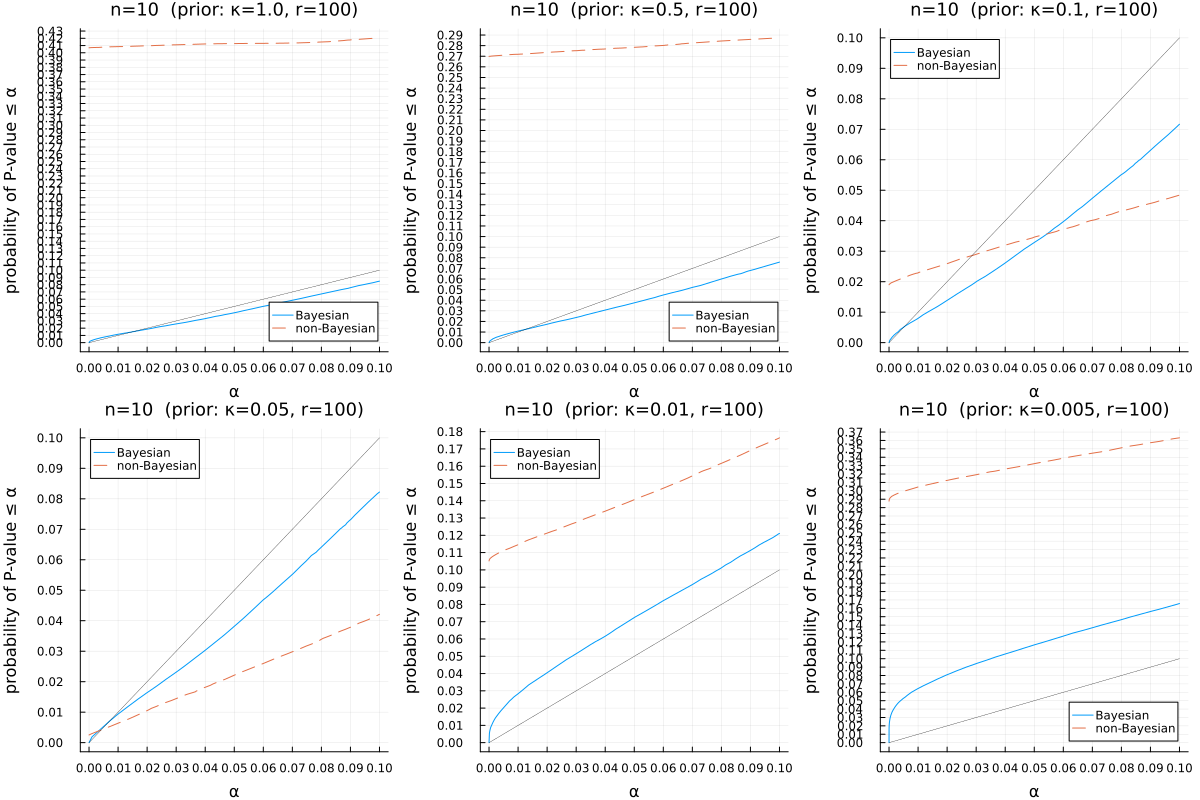

In [6]:
n = 10

PP = []
for κ in (1.0, 0.5, 0.1, 0.05, 0.01, 0.005)
    P = plot_sim_pval(; n, κ, r=100, f=Bool[1,1])
    println()
    push!(PP, P)
end

plot(PP...; size=(1200, 800), layout=(2, 3))
plot!(leftmargin=4Plots.mm)

length(κ_pri) = 100
mean(κ_pri) = 1.0
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9801980198019802
variance_sdi(prior) = 3.6950050977073694e-6
  0.165718 seconds (899.75 k allocations: 100.739 MiB, 10.74% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.5
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9705882352941176
variance_sdi(prior) = 2.0716047026682295e-5
  0.190678 seconds (899.74 k allocations: 100.739 MiB, 4.33% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.1
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9
variance_sdi(prior) = 0.0011538461538461546
  0.191989 seconds (899.74 k allocations: 100.739 MiB, 5.78% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.05
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.8249999999999996
variance_sdi(prior) = 0.0051562500000000115
  0.161022 seconds (899.74 k allocations: 100.739 MiB, 5.27% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.01
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.495
variance_sdi(prior) = 0.041662499999999936
  0.170149 seconds (899.74 k allocati

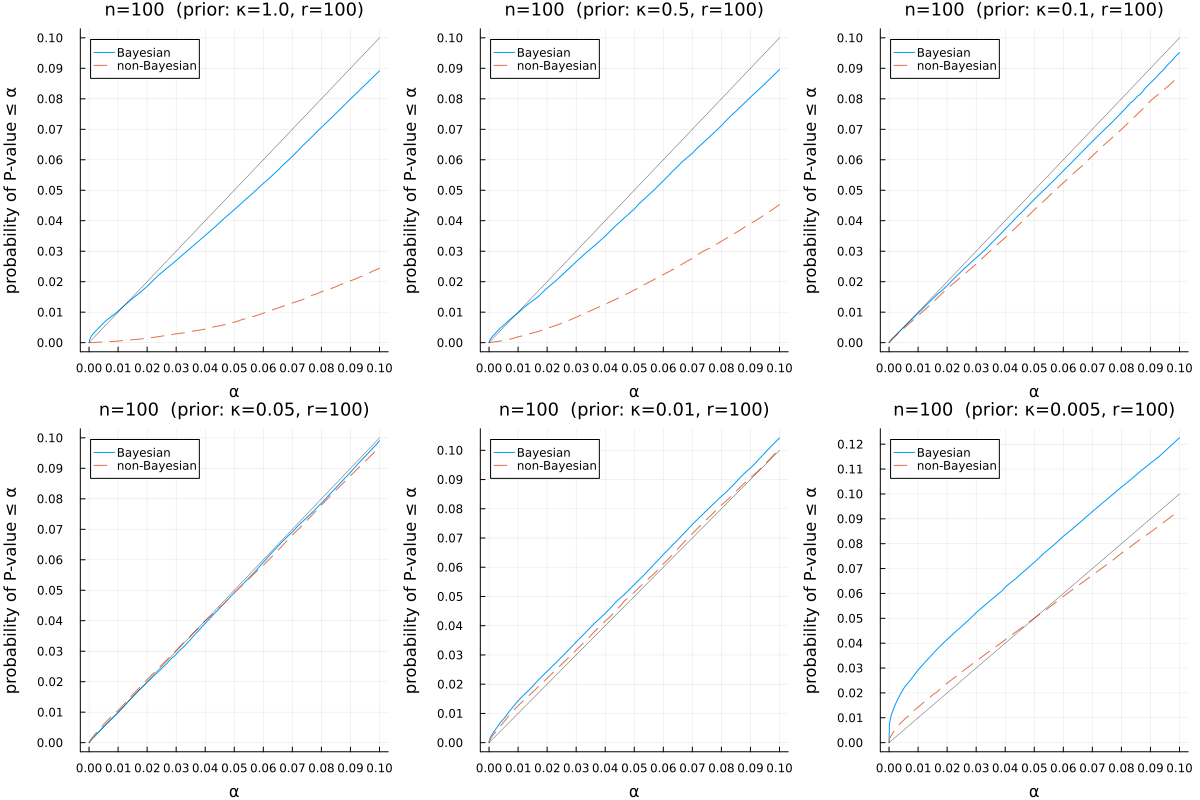

In [7]:
n = 100

PP = []
for κ in (1.0, 0.5, 0.1, 0.05, 0.01, 0.005)
    P = plot_sim_pval(; n, κ, r=100, f=Bool[1,1])
    println()
    push!(PP, P)
end

plot(PP...; size=(1200, 800), layout=(2, 3))
plot!(leftmargin=4Plots.mm)

length(κ_pri) = 100
mean(κ_pri) = 1.0
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9801980198019802
variance_sdi(prior) = 3.6950050977073694e-6
  0.188151 seconds (899.74 k allocations: 100.739 MiB, 6.99% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.5
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9705882352941176
variance_sdi(prior) = 2.0716047026682295e-5
  0.191797 seconds (899.74 k allocations: 100.739 MiB, 4.72% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.1
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.9
variance_sdi(prior) = 0.0011538461538461546
  0.168149 seconds (899.74 k allocations: 100.739 MiB, 5.58% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.05
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.8249999999999996
variance_sdi(prior) = 0.0051562500000000115
  0.193964 seconds (899.74 k allocations: 100.739 MiB, 5.28% gc time)

length(κ_pri) = 100
mean(κ_pri) = 0.01
std(κ_pri) = 0.0
expectval_sdi(prior) = 0.495
variance_sdi(prior) = 0.041662499999999936
  0.227048 seconds (899.74 k allocatio

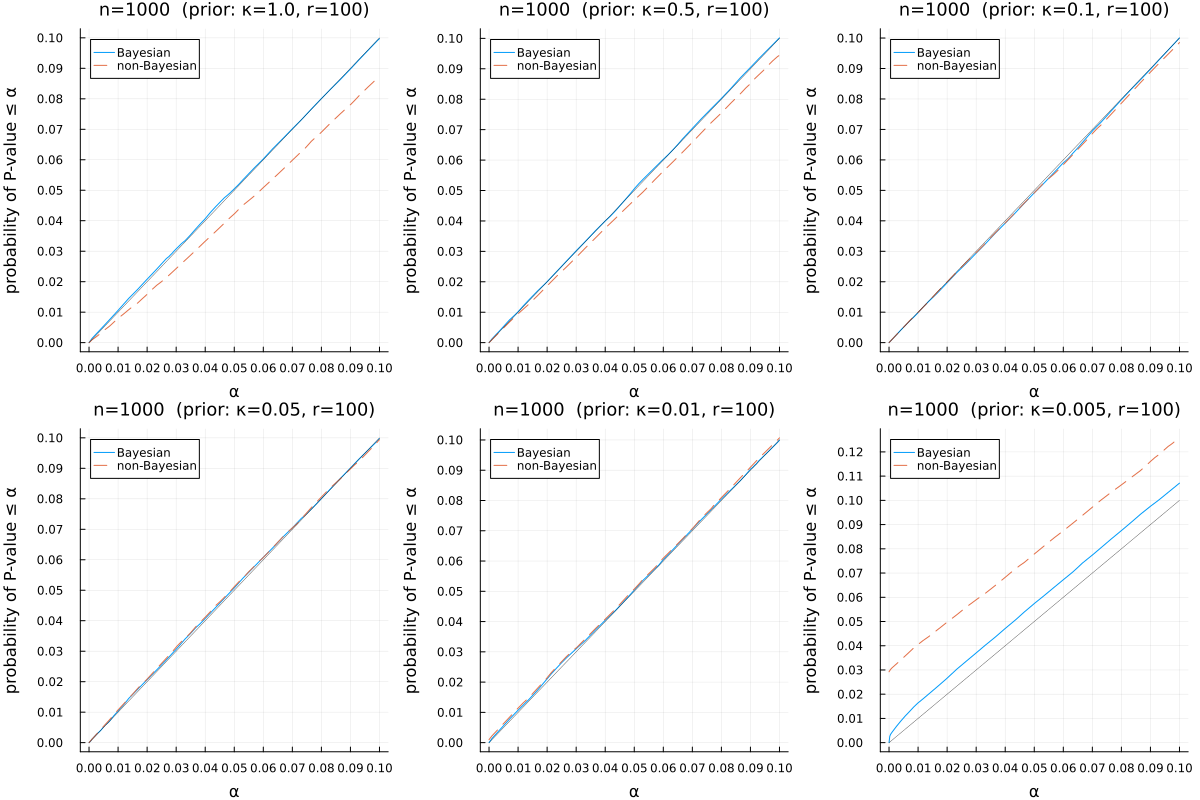

In [8]:
n = 1000

PP = []
for κ in (1.0, 0.5, 0.1, 0.05, 0.01, 0.005)
    P = plot_sim_pval(; n, κ, r=100, f=Bool[1,1])
    println()
    push!(PP, P)
end

plot(PP...; size=(1200, 800), layout=(2, 3))
plot!(leftmargin=4Plots.mm)